In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
from vqls import *
from utils import *
import matplotlib.lines as mlines

label = 'sin'
nq = 4
n_step = 16
func_out = {'sigmoid': sigmoid_t,'tanh': tanh_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}
func_list = list(func_out.keys())
func_dict = {'sigmoid': .0,'tanh': 1.0,'elu':.12, 'relu':.0, 'sin':2}

pnq = {'3':(3,8),
        '4':(4,16)}
columns=['function', 'nq', 'knot', 'training cost', 'time(s)', 'weights', 'RSS_h', 'RSS_q' ]

file_path = f"results/results_gvqs_{label}_{nq}.json"


In [3]:
df = pd.read_json(file_path)
df.head()

,Condition number,norm(yk),training_cost,exe_time,in_train_weights,RSS_q,RSS_h,seed
0,12730.232709,2.42384,"[0.39028068400000004, 0.3567349823, 0.49173851...",132477.144560,"[[1.1470130174, 1.4175051906, 1.5584195474, 0....",13.059758,11.478868,58
1,12730.232709,2.42384,"[0.3995679828, 0.4422101429, 0.464563455900000...",210812.394277,"[[2.0432109399, 1.5879286057000002, 2.76020792...",6.304146,6.092888,18
2,12730.232709,2.42384,"[0.469451781, 0.4813790076, 0.45663826, 0.4172...",212078.238044,"[[3.0159833075, 2.1975819172, 3.1411757411, 0....",6.552631,6.292682,24
3,12730.232709,2.42384,"[0.4935099719, 0.47818460970000004, 0.49414997...",210612.361122,"[[0.1513657904, 2.1393084017, 2.5091776994, 2....",13.062706,11.487276,78
4,12730.232709,2.42384,"[0.17927684230000002, 0.36585478390000004, 0.2...",164930.070595,"[[0.6744587534, 2.8572859682000002, 2.56742064...",1.557386,2.153892,96


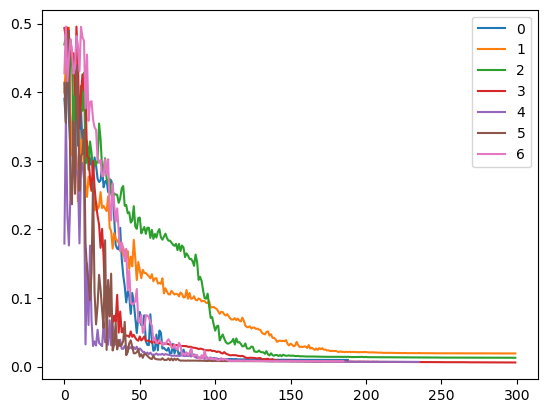

In [4]:
#Visualize training cost and obtain best performing epoch
argM = []
for i,item in enumerate(df["training_cost"].values):
    argM.append(np.argmin(item))
    plt.plot(item, label = i)
plt.legend()

beta_classic                 : [ 5.00000000e-01  8.84817516e-01 -1.83692040e+00  1.84767757e+01
 -6.90294615e+01  1.93570748e+02 -3.84342457e+02  5.78498417e+02
 -6.59846857e+02  5.78108583e+02 -3.85062210e+02  1.92631586e+02
 -7.00441143e+01  1.75416183e+01 -2.55052482e+00  5.00000000e-01]
1.0
0.9999999999999998
1.0000000000000002
0.9999999999999999
0.9999999999999999
0.9999999999999998
1.0


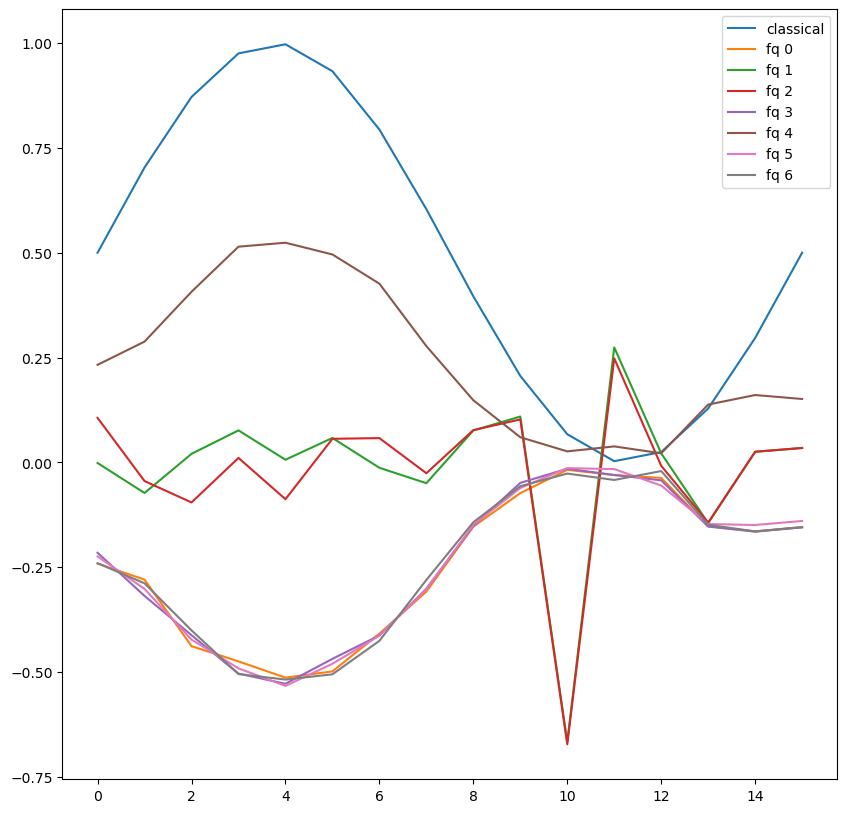

In [5]:
lower = 0. 
upper = 1. 
f_i = func_dict[label]
scaled=False
func = func_out[label]
x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
y = [func(value,f_i) for value in x]
matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled)
c = np.linalg.solve(matrix,vector)
print('beta_classic                 :',c)
plt.figure(figsize=(10,10))

y_c=np.dot(matrix,c) #classic
plt.plot(range(len(y_c)),y_c, label="classical")
k_numb=np.linalg.cond(np.array(matrix))

vqls_circuit = VQLS(matrix,v_norm,nq,opt='COBYLA') 

for i,item in enumerate(df['in_train_weights']):
  weights = item[argM[i]]
  q = vqls_circuit.solution(weights).real
  y_q=np.dot(matrix,q) #hybrid
                        #Quantum

  y_fq=[]
  for el in matrix:
    y_fq.append(vqls_circuit.direct_prod2(weights,el))
  print(np.linalg.norm(q))
  #plt.plot(range(len(y_fq)),y_q,label= f"h {i}")
  if i == 30:
    plt.plot(range(len(y_fq)),y_fq,label= f"fq {i}", linewidth = 10)
  else:
    plt.plot(range(len(y_fq)),y_fq,label= f"fq {i}")
plt.legend()

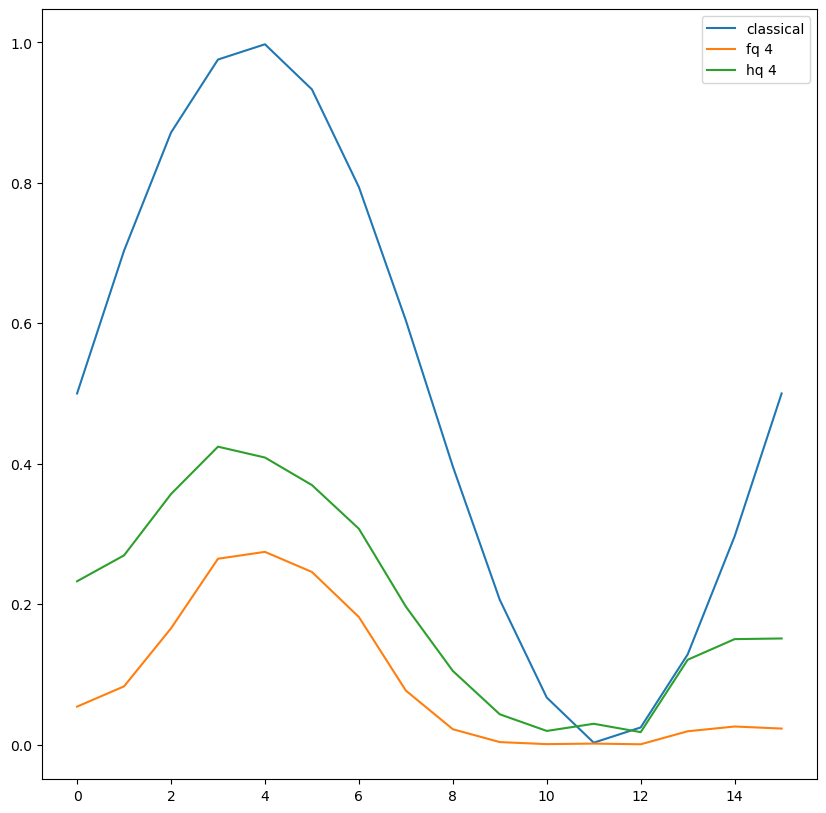

In [6]:
#Best performing model based on RSS
best = np.argmin(df['RSS_q'])


weights = df['in_train_weights'][best][argM[best]]
q = vqls_circuit.solution(weights).real
y_q=np.dot(matrix,q) #hybrid
                  #Quantum
plt.figure(figsize=(10,10))
plt.plot(range(len(y_c)),y_c, label="classical")

y_fq=[]
for el in matrix:
  y_fq.append(vqls_circuit.direct_prod2(weights,el))

#plt.plot(range(len(y_fq)),y_q,label= f"h {i}")
#plt.plot(range(len(y_fq)),np.abs(y_fq), label= f"fq abs {best}")
#plt.plot(range(len(y_fq)),np.abs(y_q), label= f"hq abs {best}")
plt.plot(range(len(y_fq)),np.power((y_fq),2), label= f"fq {best}")
plt.plot(range(len(y_fq)),(y_q), label= f"hq {best}")
plt.legend()
#plt.savefig(f'{file_path[:-5]}.png')
plt.show()

## Print approximation of best models for gvqsplines sigularly


1.77256959808715
1.803658041454714
2.485214974779029
70.39425914191047


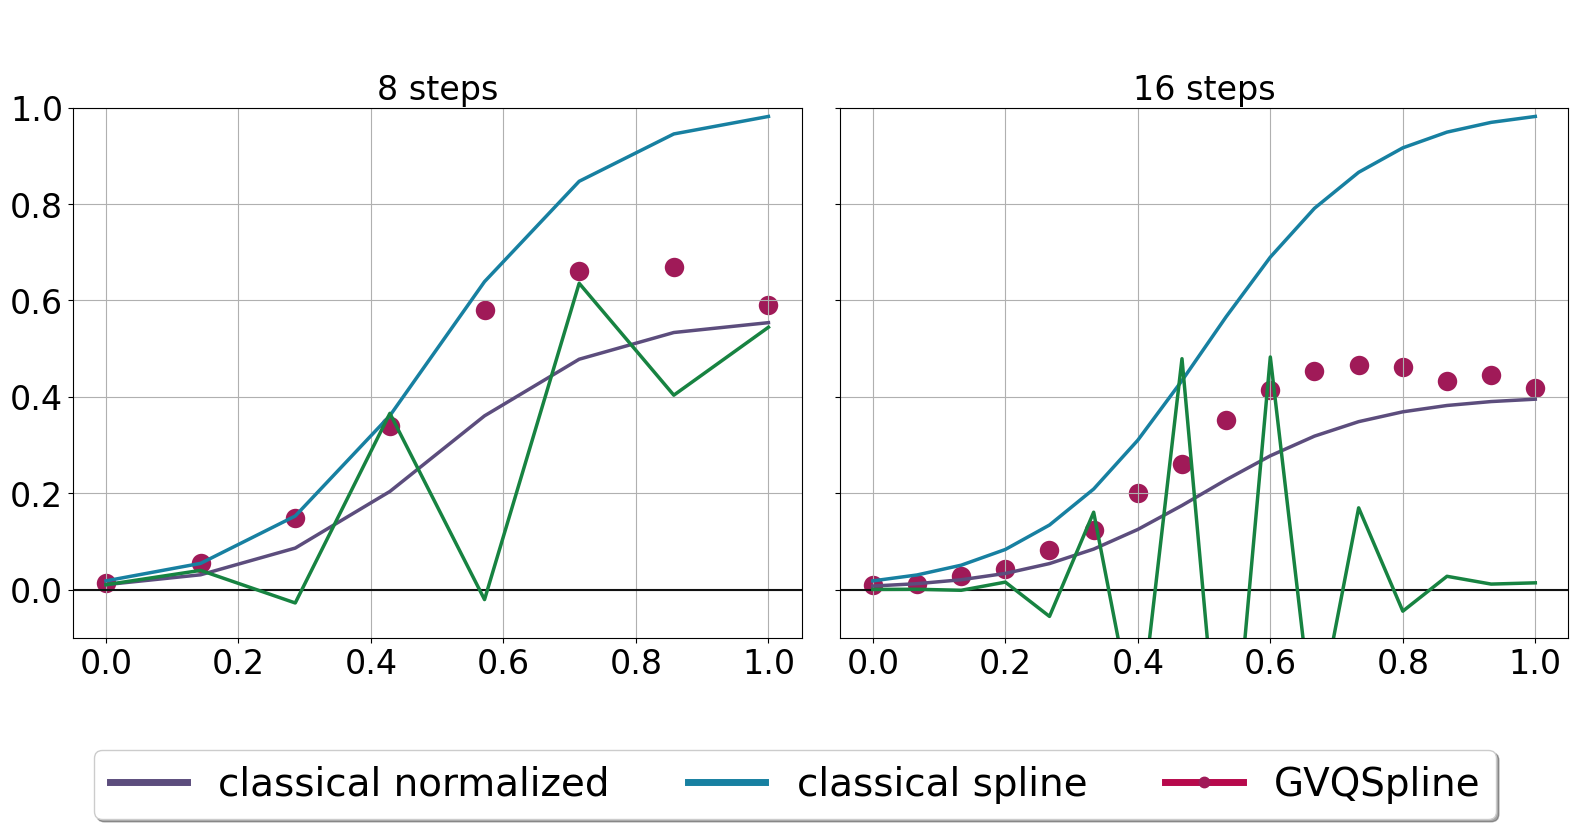

1.603072812989229
2.3759108969523184
2.2455697058697073
181.6502903466694


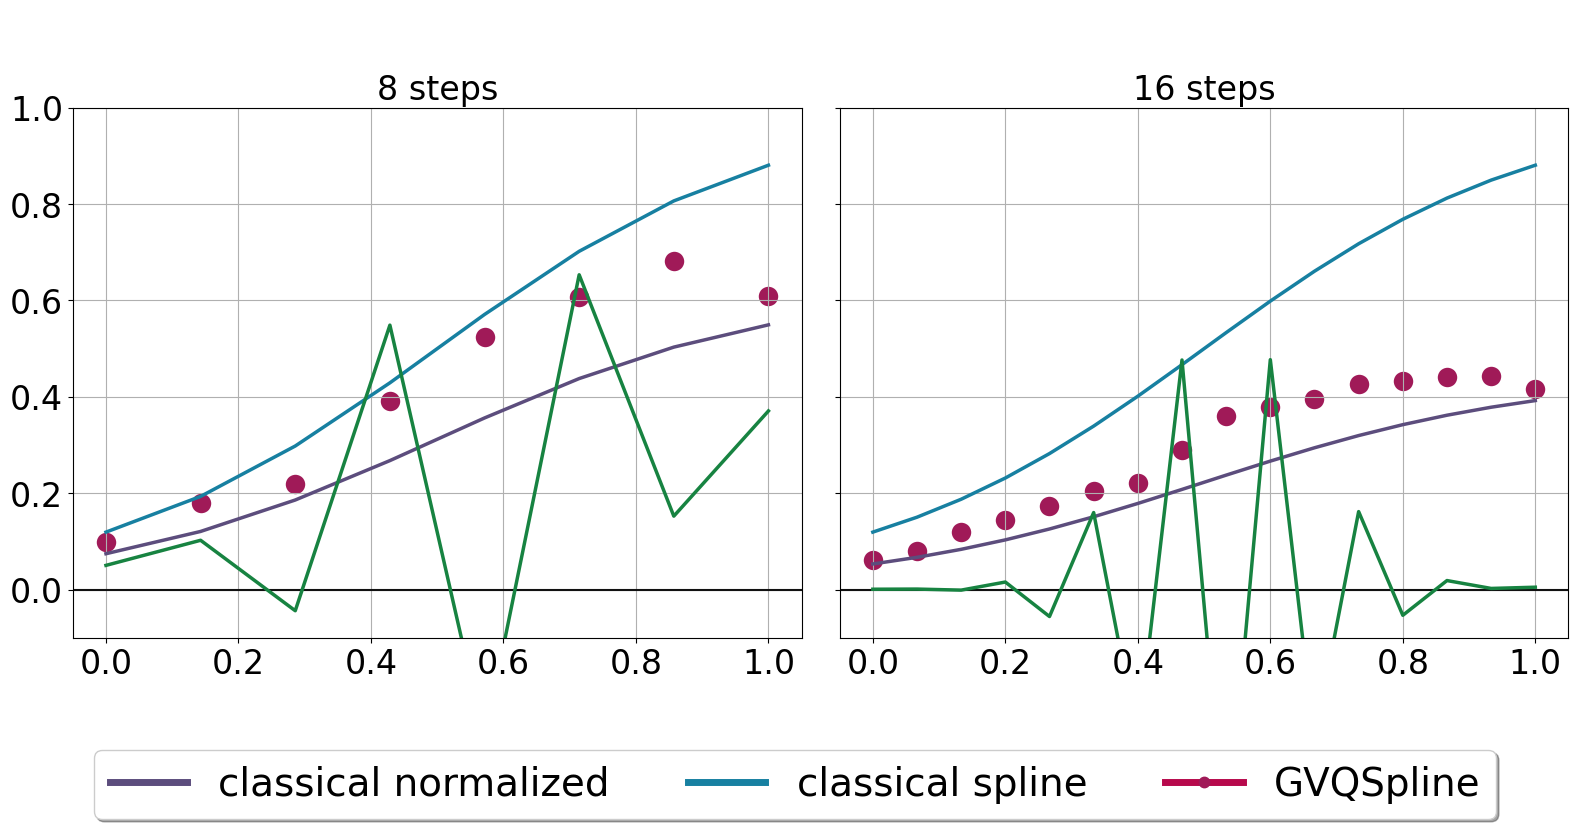

1.0760681416821176
3.882920414202471
1.46835395119374
395.8696577589781


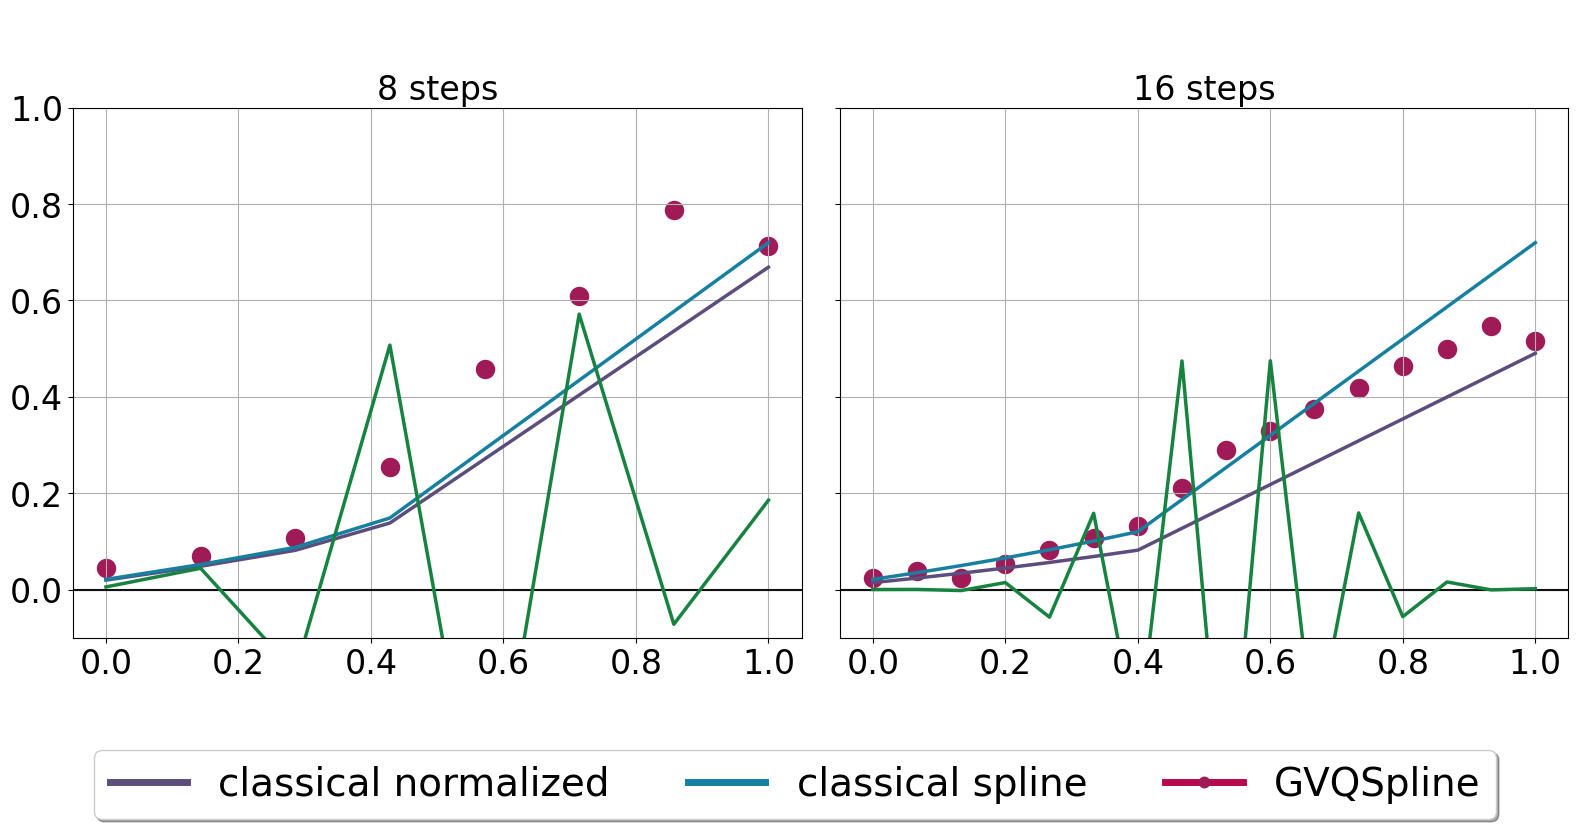

0.7798534660892573
3.816714490238927
1.0463109799035213
395.85720537681914


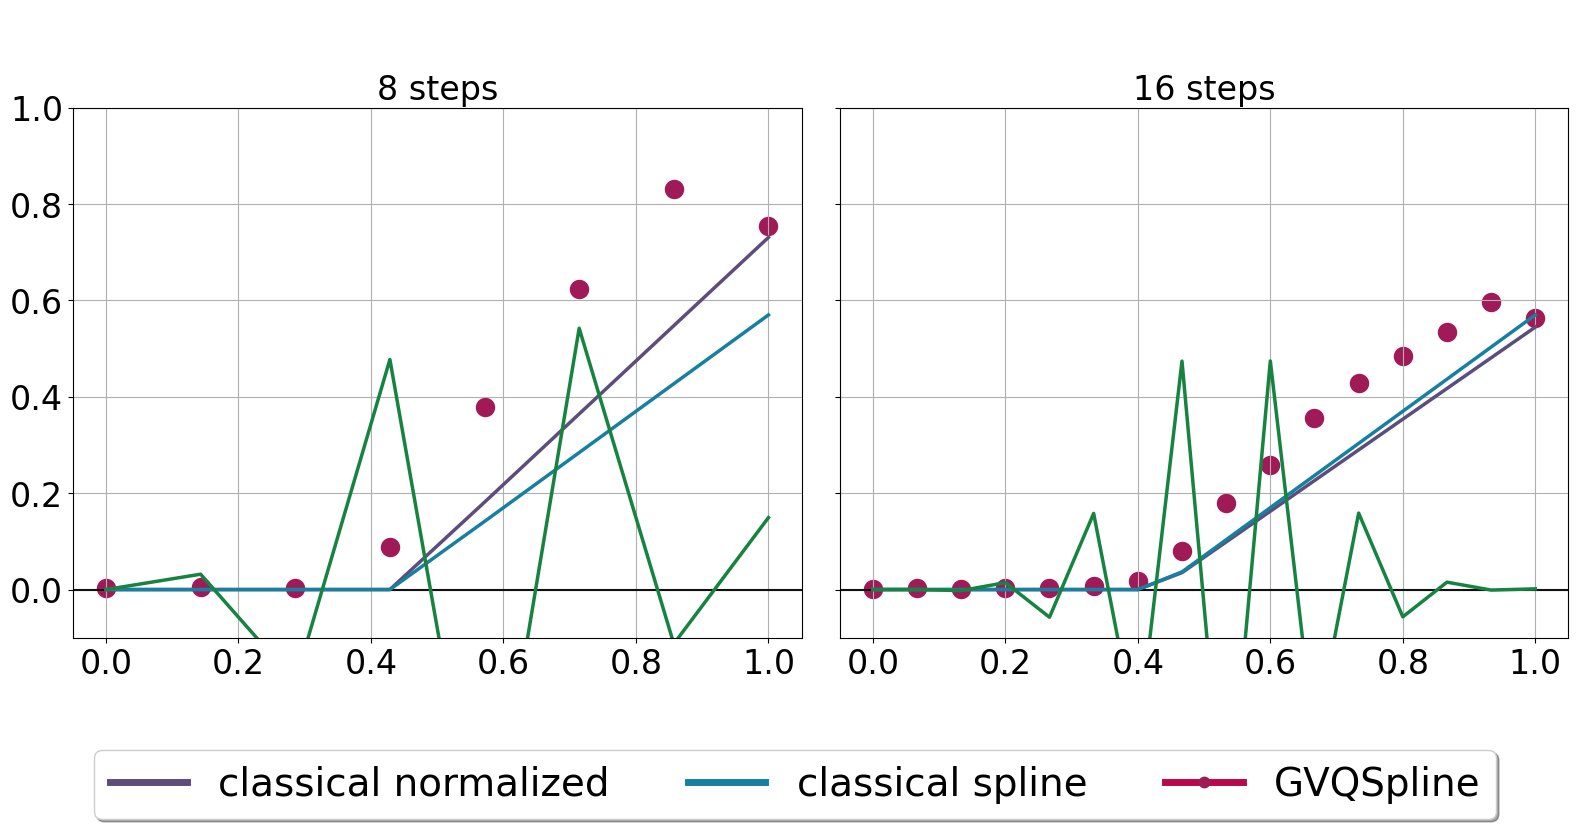

1.695582495781317
11.313992859509463
2.4238399287081647
1218.6746597120655


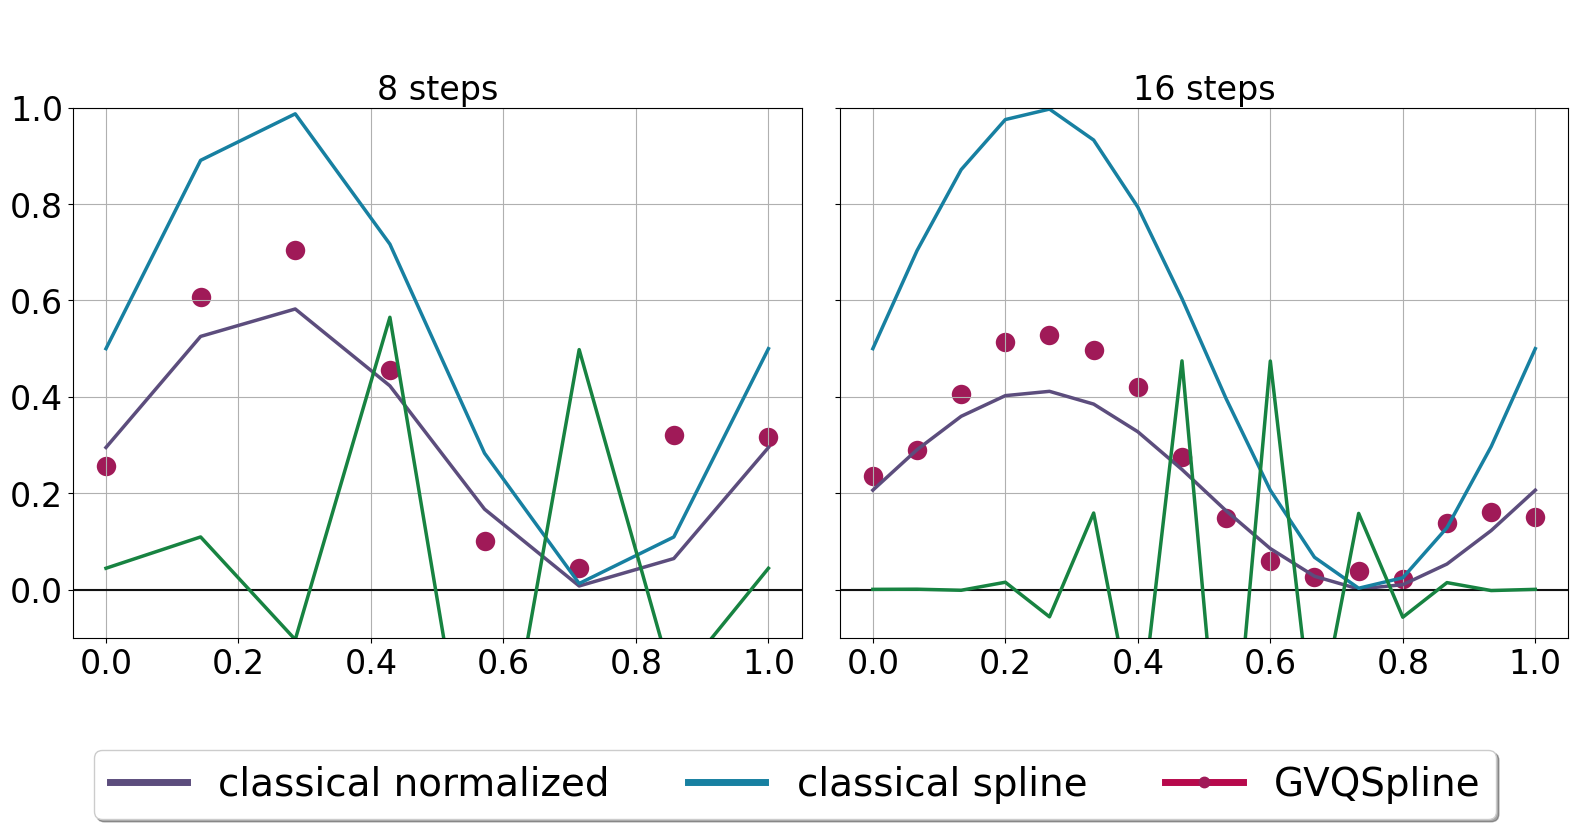

In [19]:
func_out = {'sigmoid': sigmoid_t,'tanh': tanh_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}
func_list = list(func_out.keys())
func_dict = {'sigmoid': .0,'tanh': 1.0,'elu':.12, 'relu':.0, 'sin':2}

pnq = {'3':(3,8),
        '4':(4,16)}
columns=['function', 'nq', 'knot', 'training cost', 'time(s)', 'weights', 'RSS_h', 'RSS_q' ]
tot = []
for flab, fun in func_out.items():
    for nq, knot in  pnq.values():
        file_path = f"results/results_gvqs_{flab}_{nq}.json"
        df = pd.read_json(file_path)
        best = np.argmin(df['RSS_q'])
        #if knot == 16 and flab == "sin":
        #    best = 0
        if knot == 16 and "relu" == flab:
            best = 0
        weights = df['in_train_weights'][best][-1]
        tot.append([flab, nq, knot, df.training_cost[best], df.exe_time[best], weights,df.RSS_h[best], df.RSS_q[best] ])
    
df = pd.DataFrame(tot, columns=columns)
df

j = 0
rss=[]
for flab, fun in func_out.items():
    fig = plt.figure(tight_layout = True, figsize=(16,7))
    fig.suptitle('Figure title')
    axE = fig.subfigures(1,1,)

    fig.suptitle(f'{flab}',fontsize=36)

    ax = axE.subplots(nrows=1, ncols=2, sharey=True,)

    ax[0].set_ylim(-0.1,1)
    
    j-=-1
    dl = df[df['function'] == flab]
    dl.reset_index(drop=True, inplace=True)
    #x = np.linspace(0, 1, 16).tolist() 
    #for el in x:
    #    plt.axvline(el, color = '#993333', alpha=0.2)
    #x = np.linspace(0, 1, 8).tolist() 
    #for el in x:
    #    plt.axvline(el, color = '#b300b3', alpha=0.2)
    for i, el in dl.iterrows():
        lower = 0.
        upper = 1.
        ax[i].tick_params(axis='both', which='major', labelsize=24)
        ax[i].grid(zorder = -3)

        f_i = func_dict[flab]
        scaled=False    
        label = flab
        n_step = el.knot
        x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
        xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
        y = [fun(value,f_i) for value in xx]

        #tck=splrep(x,y,k=1) #coeffs
        norm = np.linalg.norm(y)
        y = y / norm
        ax[i].plot(np.linspace(lower,upper,len(y)),y, label=f"Original function scaled {n_step}", color = '#5c4d7d',linewidth=2.5)

        ax[i].axhline(0, color="#111111")
        
        matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled)

        vqls_circuit = VQLS(matrix,v_norm,el['nq'],opt='COBYLA') 

        c = np.linalg.solve(matrix,vector)

        y_c=np.dot(matrix,c) #classic
        ax[i].plot(np.linspace(lower,upper,len(y_c)),vector, label="classical spline", color = '#1780a1',linewidth=2.5)

        y_fq=[]
        q = vqls_circuit.solution(el['weights']).real
        y_q=np.dot(matrix,q) #hybrid
                        #Quantum

        for a in matrix:
            y_fq.append(vqls_circuit.direct_prod2(el['weights'],a))
        rssss = math.sqrt(np.square(np.subtract(y_c,np.abs(y_fq))).mean())
        rssss2 = math.sqrt(np.square(np.subtract(y,np.abs(y_fq))).mean())
        rss.append(rssss)
        colorl = '#b7094c'
        colors = '#a01a58'
        #ax[i].plot(np.linspace(lower,upper,len(y_fq)),np.abs(y_fq),label= f"full quantum {n_step}", color=colorl, zorder= -1, lw=5)
        ax[i].scatter(np.linspace(lower,upper,len(y_fq)),np.abs(y_fq), color=colors, linewidths=8)
        #plt.scatter(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
        #plt.plot(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
        #ax[i].text(0.35,0.87, f"rmse scaled = {rssss2:.4f}\n" \
        #    f"rmse classical = {rssss:.4f}\n", fontsize=14)
        ax[i].set_title(f'{n_step} steps',fontsize=24)


        #ax[i].legend(fontsize=18)
    handles = [mlines.Line2D([], [], color='#5c4d7d', linewidth=5, label='classical normalized')]
    handles.append(mlines.Line2D([], [], color='#1780a1', linewidth=5, label='classical spline'))
    handles.append(mlines.Line2D([], [], color=colorl, marker='.',linewidth=5,
                        markersize=15, label='GVQSpline', markerfacecolor=colors, markeredgecolor=colors))

    lgd = axE.legend(handles = handles, loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5, fontsize = 28)
    #fig.savefig(f'plots/n_gvqs_{flab}_plot.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

    plt.show()






## Print approximation of best models for gvqspline


In [7]:
func_out = {'sigmoid': sigmoid_t,'tanh': tanh_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}
func_list = list(func_out.keys())
func_dict = {'sigmoid': .0,'tanh': 1.0,'elu':.12, 'relu':.0, 'sin':2}

pnq = {'3':(3,8),
        '4':(4,16)}
columns=['function', 'nq', 'knot', 'training cost', 'time(s)', 'weights', 'RSS_h', 'RSS_q' ]
tot = []
for flab, fun in func_out.items():
    for nq, knot in  pnq.values():
        file_path = f"results_{flab}_{nq}.json"
        df = pd.read_json(file_path)
        best = np.argmin(df['RSS_q'])
        #if knot == 16 and flab == "sin":
        #    best = 0
        if knot == 16 and "relu" == flab:
            best = 0
        weights = df['in_train_weights'][best][-1]
        tot.append([flab, nq, knot, df.training_cost[best], df.exe_time[best], weights,df.RSS_h[best], df.RSS_q[best] ])
    
df = pd.DataFrame(tot, columns=columns)
df

fig = plt.figure(constrained_layout=True, figsize=(15,30))
fig.suptitle('Figure title')
axE = fig.subfigures(5,1,  )
j = 0
rss=[]
for flab, fun in func_out.items():
    axE[j].suptitle(f'{flab}',fontsize=30)

    ax = axE[j].subplots(nrows=1, ncols=2, sharey=True,)

    ax[0].set_ylim(-0.1,1)

    j-=-1
    dl = df[df['function'] == flab]
    dl.reset_index(drop=True, inplace=True)
    #x = np.linspace(0, 1, 16).tolist() 
    #for el in x:
    #    plt.axvline(el, color = '#993333', alpha=0.2)
    #x = np.linspace(0, 1, 8).tolist() 
    #for el in x:
    #    plt.axvline(el, color = '#b300b3', alpha=0.2)
    for i, el in dl.iterrows():
        lower = 0.
        upper = 1.

        f_i = func_dict[flab]
        scaled=False    
        label = flab
        n_step = el.knot
        x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
        xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
        y = [fun(value,f_i) for value in xx]

        #tck=splrep(x,y,k=1) #coeffs
        norm = np.linalg.norm(y)
        y = y / norm
        ax[i].plot(np.linspace(lower,upper,len(y)),y, label=f"Original function scaled {n_step}", color = '#5c4d7d',linewidth=2.5)

        ax[i].axhline(0, color="#222222")
        
        matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled)

        vqls_circuit = VQLS(matrix,v_norm,el['nq'],opt='COBYLA') 

        c = np.linalg.solve(matrix,vector)

        y_c=np.dot(matrix,c) #classic
        ax[i].plot(np.linspace(lower,upper,len(y_c)),vector, label="classical spline", color = '#1780a1',linewidth=2.5)

        y_fq=[]
        q = vqls_circuit.solution(el['weights']).real
        y_q=np.dot(matrix,q) #hybrid
                        #Quantum

        for a in matrix:
            y_fq.append(vqls_circuit.direct_prod2(el['weights'],a))
        rssss = math.sqrt(np.square(np.subtract(y_c,np.abs(y_fq))).mean())
        rssss2 = math.sqrt(np.square(np.subtract(y,np.abs(y_fq))).mean())
        rss.append(rssss)
        colorl = '#b7094c'
        colors = '#a01a58'
        #ax[i].plot(np.linspace(lower,upper,len(y_fq)),np.abs(y_fq),label= f"full quantum {n_step}", color=colorl)
        ax[i].scatter(np.linspace(lower,upper,len(y_fq)),np.abs(y_fq), color=colors, linewidths=4)
        #plt.scatter(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
        #plt.plot(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
        ax[i].text(0.4,0.9, f"rmse scaled = {rssss2:.4f}\n" \
            f"rmse classical = {rssss:.4f}\n")
        ax[i].set_title(f'{n_step} steps')
        ax[i].legend()
        ax[i].grid()
#plt.savefig(f'full_plots.png')
plt.show()



FileNotFoundError: File results_sigmoid_3.json does not exist

#  Print VQSpline

21


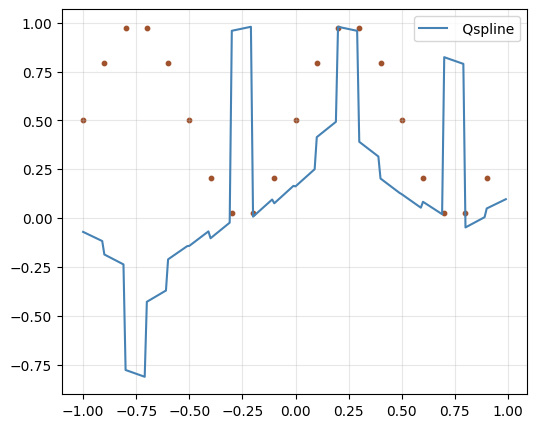

In [ ]:
X = []
n_step = 20
step = (1-(-1))/n_step

x = np.arange(-1, 1 + .03, step).tolist()
from utils import *
func = sin_m
f_i =0
print(len(x))
y = [func(value,f_i) for value in x]

for i in range(1, len(x)):
    X.append(np.arange(x[i - 1], x[i], step - 0.01).tolist())
    

#################################
######### Inner Product #########
#################################

qc_full = []
classic_prod = []
vqls_circuit = qProduct(1)
for i in range(len(X)):
    for x in X[i]:
        point = [1,x]
        #quantum_prod with/without norm
        norm = 1
        qc_full.append(vqls_circuit.direct_prod2(weights[i],point,visualize=False)*norm)  

x = [item for sublist in X for item in sublist]
y = [func(value,f_i) for value in x]


##### TODO: ???????????????????????????????????????????????????????????????????
'''
if label == 'tanh':
    qc_full = [q - 0.2 for q in qc_full] 
if label == 'elu':
    classic_prod = [c -f_i for c in classic_prod]
    qc_full = [c-f_i for c in qc_full]
'''

x1=[i for j,i in enumerate(x) if j%2==0]
y1=[i for j,i in enumerate(y) if j%2==0]


fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(x, qc_full, color='steelblue',label=' Qspline') 
ax.scatter(x1,y1,color='sienna',s=10)
ax.grid(alpha=0.3)
plt.legend(loc='best')
plt.show()
plt.close()